# AI prep workbook

## Reading in Parquet and CSV files

In [ ]:
import os
import pandas as pd
from scripts.csvtoparquet import csv_to_parquet_single_file

# Example usage
current_directory = os.getcwd()
csv_file_path = os.path.join(current_directory, 'input', 'train_labels.csv')
output_file_path = os.path.join(current_directory, 'input', 'full_labels.parquet')

chunksize = 100000
sample_rows = 100000


csv_to_parquet_single_file(csv_file_path, output_file_path, chunksize=chunksize, sample_rows=sample_rows)



In [ ]:
import os
import pandas as pd
from scripts.parquetreader import read_parquet_file 

current_directory = os.getcwd()

training = os.path.join(current_directory, 'input', 'full_data.parquet')
labels = os.path.join(current_directory, 'input', 'full_labels.parquet')

dftrain=read_parquet_file(training)

dflabels=read_parquet_file(labels)
dflabels.drop_duplicates(inplace=True)

print('training',dftrain.shape[0])
print(dftrain['D_64'].dtype)

print('labels',dftrain.shape[0])


In [ ]:
import pandas as pd
import os

# Assuming dftrain and dflabels are defined and available
# If possible, optimize data types in dftrain and dflabels before this operation

# Efficient merging by subsetting dflabels to only necessary columns before merge
result_df = pd.merge(dftrain, dflabels[['customer_ID', 'target']], on='customer_ID', how='inner')

# In-place operations for efficiency
result_df.drop(columns=['D_64','D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_142'], inplace=True)
result_df.fillna(0, inplace=True)

# Prepare file path
current_directory = os.getcwd()
output_file_sampledparquet = os.path.join(current_directory, 'input', 'sample_trainingdata.parquet')

# Save to Parquet with optimization
result_df.to_parquet(output_file_sampledparquet, engine='pyarrow', compression='snappy')


In [1]:
import pandas as pd
import os

current_directory = os.getcwd()
parquet_file_path = os.path.join(current_directory, 'input', 'sample_trainingdata.parquet')


# Read the Parquet file
dfmodelstep1 = pd.read_parquet(parquet_file_path)

# Now you can work with your DataFrame 'df'
print(dfmodelstep1.shape[0])
unique_customer_ids = dfmodelstep1['customer_ID'].nunique()
print(unique_customer_ids)

1204174
100000


## Train/Testsplit

In [2]:
from sklearn.model_selection import train_test_split

# Split the dataset into features and target
# Replace 'target_column_name' with the name of your target column
X = dfmodelstep1.drop(columns=['target', 'customer_ID'])
y = dfmodelstep1['target']

# Split the data into training and test sets
# test_size=0.2 means 20% of the data will be used for the test set, and 80% for the training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

print('X train',X_train.shape[0])
print('Y train',y_train.shape[0])
print('X test',X_test.shape[0])
print('Y test',y_test.shape[0])

X train 722504
Y train 722504
X test 481670
Y test 481670


Epoch 1/20


/Users/danramirez/mbs-transformers/new_env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.7248 - loss: 0.5209 - val_accuracy: 0.9280 - val_loss: 0.2207
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.9053 - loss: 0.2605 - val_accuracy: 0.9589 - val_loss: 0.1406
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.9367 - loss: 0.1900 - val_accuracy: 0.9750 - val_loss: 0.0979
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.9565 - loss: 0.1635 - val_accuracy: 0.9804 - val_loss: 0.0818
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.9665 - loss: 0.1266 - val_accuracy: 0.9815 - val_loss: 0.0727
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.9734 - loss: 0.1105 - val_accuracy: 0.9839 - val_loss: 0.0688
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.9738 - loss: 0.1020 - val_accuracy: 0.9845 - val_loss: 0.0660
Epoch 8/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.9775 - loss: 0.0917 - val_accurac

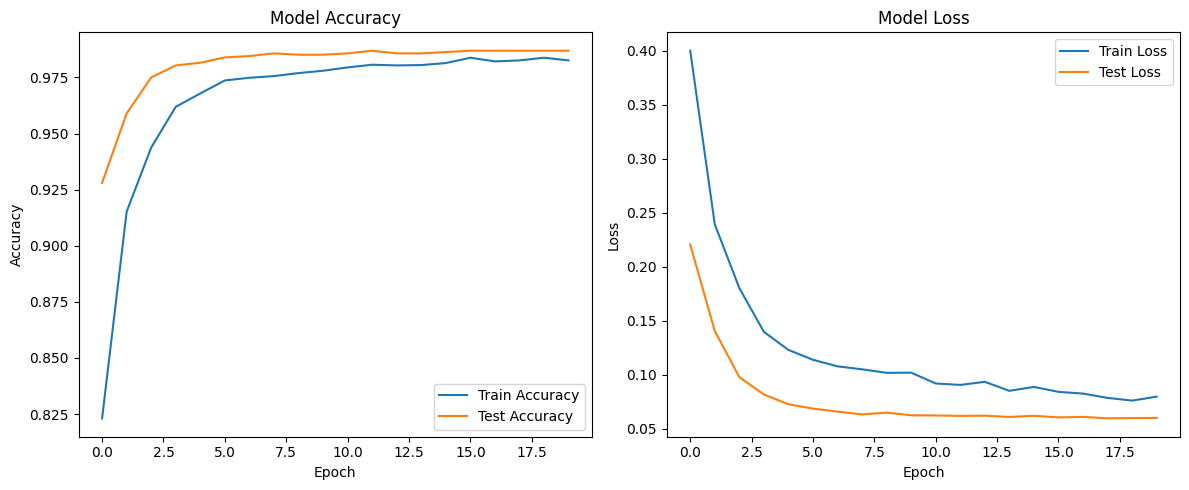

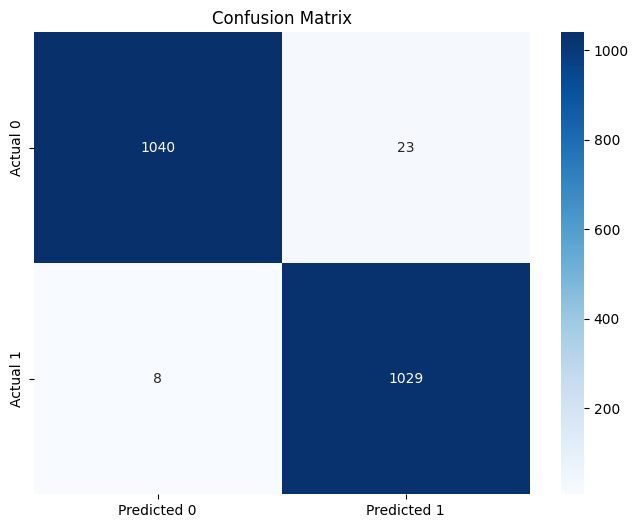

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Generate example dataset
X, y = make_classification(n_samples=10500, n_features=20, n_classes=2, random_state=42)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the model architecture
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
print('')
# Predict and evaluate
y_pred_prob = model.predict(X_test)
print("Predictions shape:", y_pred_prob.shape)
print("Number of predictions:", len(y_pred_prob))
print("Number of test instances:", len(X_test))

y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate and print model accuracy on the test dataset
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy on Test Dataset: {test_accuracy:.2f}")


# Visualization of training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.show()




# Upload parquet to Blob Storage

In [ ]:
from azure.storage.blob import BlobServiceClient, BlobClient,ContainerClient 
import os
from dotenv import load_dotenv
load_dotenv()
connection_str = os.getenv('connection_str')


# Azure storage account detail
container_name = 'trainingdata'

# File to upload
current_directory = os.getcwd()
parquet_file_path = os.path.join(current_directory, 'input', 'sample_trainingdata.parquet')

# Create the BlobServiceClient object which will be used to create a container client
blob_service_client = BlobServiceClient.from_connection_string(connection_str)

# Create the container client
container_client = blob_service_client.get_container_client(container_name)

# Create a blob client using the local file name as the name for the blob
blob_client = blob_service_client.get_blob_client(container=container_name, blob=os.path.basename(parquet_file_path))

print(f"Uploading to Azure Storage as blob:\n\t {os.path.basename(parquet_file_path)}")

# Upload the created file
with open(parquet_file_path, "rb") as data:
    blob_client.upload_blob(data, overwrite=True)

print("Upload completed successfully")


# Reading Parquet File

In [ ]:
import pandas as pd
from azure.storage.blob import BlobServiceClient
from io import BytesIO
from dotenv import load_dotenv
load_dotenv()
connection_str = os.getenv('connection_str')

# Initialize a BlobServiceClient
blob_service_client = BlobServiceClient.from_connection_string(connection_str)

# Specify your container and the name for the file in the container
container_name = 'trainingdata'
blob_name = 'new_train_data.parquet'

def read_parquet_file_from_blob(connection_str, container_name, blob_name):

    blob_service_client = BlobServiceClient.from_connection_string(connection_str)
    blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)
    
    stream = BytesIO()
    blob_client.download_blob().download_to_stream(stream)
    stream.seek(0)  # Go to the start of the stream
    df = pd.read_parquet(stream)
    
    return df

